# Por dentro da função pipeline (TensorFlow)

Install the Transformers, Datasets, and Evaluate libraries to run this notebook.

In [1]:
!pip install datasets evaluate transformers[sentencepiece]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.9 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.


In [2]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis")
classifier(
    [
        "I've been waiting for a HuggingFace course my whole life.",
        "I hate this so much!",
    ]
)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that aut

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

[{'label': 'POSITIVE', 'score': 0.9598048329353333},
 {'label': 'NEGATIVE', 'score': 0.9994558691978455}]

Como visto na aula anterior![image1.jpg](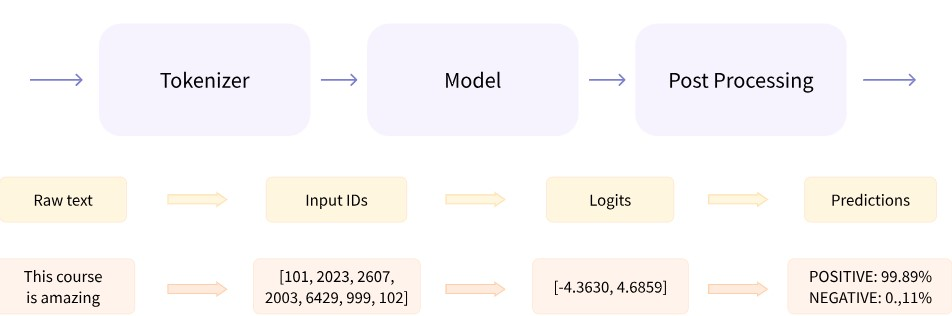![image2.jpg](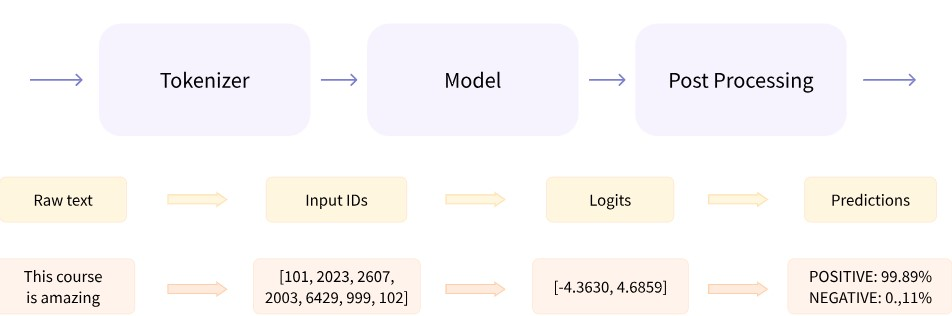)), este pipeline agrupa os três passos: o pré-processamento, passagem das entradas através do modelo, e o pós-processamento:

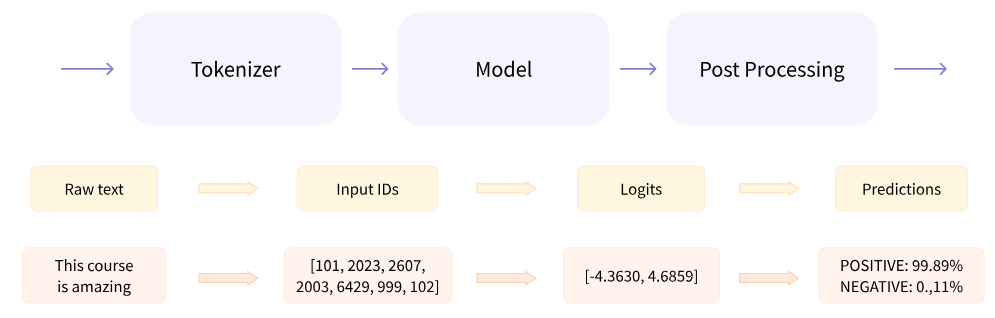

Vamos rever rapidamente cada um deles.

#Pré-processamento com o tokenizer
Como outras redes neurais, os Transformers não podem processar texto bruto diretamente, portanto, o primeiro passo do nosso pipeline é converter as entradas de texto em números que o modelo possa fazer sentido. Para fazer isso, usamos um tokenizer, que será responsável por:

Dividir a entrada em palavras, sub-palavras ou símbolos (como pontuação) que são chamados de tokens.

Mapeando cada ficha para um número inteiro
Adicionando entradas adicionais que podem ser úteis ao modelo
Todo esse pré-processamento precisa ser feito exatamente da mesma forma que quando o modelo foi pré-treinado, então precisamos primeiro baixar essas informações do Model Hub.

Para isso, utilizamos a classe AutoTokenizer e seu método from_pretrained().

Utilizando o nome do ponto de verificação de nosso modelo, ele irá buscar automaticamente os dados associados ao tokenizer do modelo e armazená-los em cache (portanto, ele só é baixado na primeira vez que você executar o código abaixo).

Desde que o checkpoint default do pipeline sentiment-analysis é distilbert-base-uncased-finetuned-sst-2-english (você pode ver o card do modelo aqui), então executamos o seguinte:

In [3]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Assim que tivermos o tokenizer, podemos passar diretamente nossas frases para ele e receberemos de volta um dicionário que está pronto para alimentar nosso modelo! A única coisa que falta fazer é converter a lista de identificações de entrada em tensores.

Você pode usar 🤗 Transformers sem ter que se preocupar com qual estrutura ML é usada como backend; pode ser PyTorch ou TensorFlow, ou Flax para alguns modelos. Entretanto, os Transformers só aceitam tensores como entrada. Se esta é a primeira vez que você ouve falar de tensores, você pode pensar neles como matrizes da NumPy. Uma matriz NumPy pode ser um escalar (0D), um vetor (1D), uma matriz (2D), ou ter mais dimensões. É efetivamente um tensor; os tensores de outras estruturas ML comportam-se de forma semelhante, e geralmente são tão simples de instanciar como os arrays da NumPy.

Para especificar o tipo de tensores que queremos recuperar (PyTorch, TensorFlow ou NumPy), utilizamos o argumento return_tensors:

In [4]:
raw_inputs = [
    "I've been waiting for a HuggingFace course my whole life.",
    "I hate this so much!",
]
inputs = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors="tf")
print(inputs)

{'input_ids': <tf.Tensor: shape=(2, 16), dtype=int32, numpy=
array([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662,
        12172,  2607,  2026,  2878,  2166,  1012,   102],
       [  101,  1045,  5223,  2023,  2061,  2172,   999,   102,     0,
            0,     0,     0,     0,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 16), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>}


Não se preocupe ainda com o truncamento e o padding; explicaremos isso mais tarde. As principais coisas a lembrar aqui são que você pode passar uma frase ou uma lista de frases, bem como especificar o tipo de tensores que você quer recuperar (se nenhum tipo for passado, você receberá uma lista de listas como resultado).

Eis como são os resultados como tensores TensorFlow:

A saída em si é um dicionário contendo duas chaves, input_ids' e attention_mask’. O `input_ids’ contém duas linhas de inteiros (uma para cada frase) que são os identificadores únicos dos tokens em cada frase. Explicaremos o que é a “máscara de atenção” (attention mask) mais adiante neste capítulo.

Indo adianta pelo modelo
Podemos baixar nosso modelo pré-treinado da mesma forma que fizemos com nosso tokenizer. 🤗 Transformers fornece uma classe “TFAutoModel” que também tem um método “from_pretrained”:

In [5]:
from transformers import TFAutoModel

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = TFAutoModel.from_pretrained(checkpoint)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Neste trecho de código, fizemos o download do mesmo checkpoint que usamos anteriormente em nosso pipeline (já deveria estar em cache) e instanciamos um modelo com ele.

Esta arquitetura contém apenas o módulo base do Transformer: dadas algumas entradas, ele produz o que chamaremos de hidden states (estados ocultos), também conhecidos como features (características). Para cada modelo de entrada, recuperaremos um vetor de alta dimensionalidade representando a compreensão contextual dessa entrada pelo Transformer*.

Se isto não faz sentido, não se preocupe com isso. Explicaremos tudo isso mais tarde.

Embora estes hidden states possam ser úteis por si mesmos, eles geralmente são entradas para outra parte do modelo, conhecida como head (cabeça). No Capítulo 1, as diferentes tarefas poderiam ter sido realizadas com a mesma arquitetura, mas cada uma destas tarefas teria uma head diferente associada a ela.

Um vetor de alta dimensionalidade?
A saída vetorial pelo módulo do Transformer é geralmente grande. Geralmente tem três dimensões:

Tamanho do lote (Batch size): O número de sequências processadas de cada vez (2 em nosso exemplo).
Tamanho da sequencia (Sequence length): O comprimento da representação numérica da sequência (16 em nosso exemplo).
Tamanho oculto (Hidden size): A dimensão vetorial de cada modelo de entrada.
Diz-se que é “de alta dimensionalidade” por causa do último valor. O tamanho oculto pode ser muito grande (768 é comum para modelos menores, e em modelos maiores isto pode chegar a 3072 ou mais).

Podemos ver isso se alimentarmos os inputs que pré-processamos para nosso modelo:

In [6]:
outputs = model(inputs)
print(outputs.last_hidden_state.shape)

(2, 16, 768)


Observe que as saídas dos 🤗 Transformer se comportam como ‘tuplas nomeadas’ (namedtuple) ou dicionários. Você pode acessar os elementos por atributos (como fizemos) ou por chave (outputs["last_hidden_state"]), ou mesmo por índice se você souber exatamente onde o que está procurando (outputs[0]).

Cabeça do modelo (model heads): Fazendo sentido a partir dos números
As heads do modelo usam o vetor de alta dimensionalidade dos hidden states como entrada e os projetam em uma dimensão diferente. Eles são geralmente compostos de uma ou algumas camadas lineares:

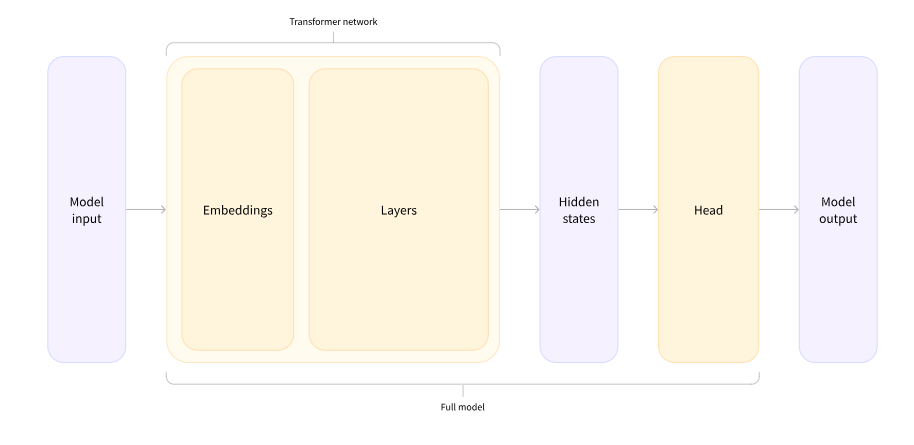

A saída do Transformer é enviada diretamente para a head do modelo a ser processado.

Neste diagrama, o modelo é representado por sua camada de embeddings (vetores) e pelas camadas subsequentes. A camada de embeddings converte cada ID de entrada na entrada tokenizada em um vetor que representa o token associado. As camadas subsequentes manipulam esses vetores usando o mecanismo de atenção para produzir a representação final das sentenças.

Há muitas arquiteturas diferentes disponíveis no 🤗 Transformers, com cada uma projetada em torno de uma tarefa específica. Aqui está uma lista por algumas destas tarefas:

*Model (recuperar os hidden states)

*ForCausalLM

*ForMaskedLM

*ForMultipleChoice

*ForQuestionAnswering

*ForSequenceClassification

*ForTokenClassification

e outros 🤗
Para nosso exemplo, precisaremos de um modelo com uma head de classificação em sequencia (para poder classificar as sentenças como positivas ou negativas). Portanto, não utilizaremos a classe TFAutoModel, mas sim, a classe TFAutoModelForSequenceClassification:



In [7]:
from transformers import TFAutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint)
outputs = model(inputs)

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


Agora se observarmos o tamanho dos nossos inputs, a dimensionalidade será muito menor: a head do modelo toma como entrada os vetores de alta dimensionalidade que vimos anteriormente, e os vetores de saída contendo dois valores (um por label):

In [8]:
print(outputs.logits.shape)

(2, 2)


Como temos apenas duas sentenças e duas labels, o resultado que obtemos de nosso modelo é de tamanho 2 x 2.

##Pós-processamento da saída
Os valores que obtemos como resultado de nosso modelo não fazem necessariamente sentido sozinhos. Vamos dar uma olhada:

In [9]:
print(outputs.logits)

tf.Tensor(
[[-1.5606961  1.6122813]
 [ 4.1692314 -3.3464477]], shape=(2, 2), dtype=float32)


Nosso modelo previu [-1.5607, 1.6123] para a primeira frase e [ 4.1692, -3.3464] para a segunda. Essas não são probabilidades, mas logits, a pontuação bruta e não normalizada produzida pela última camada do modelo. Para serem convertidos em probabilidades, eles precisam passar por uma camada SoftMax (todas saídas dos 🤗 Transformers produzem logits, já que a função de loss (perda) para treinamento geralmente fundirá a última função de ativação, como SoftMax, com a função de loss real, por exemplo a cross entropy):

In [10]:
import tensorflow as tf

predictions = tf.math.softmax(outputs.logits, axis=-1)
print(predictions)

tf.Tensor(
[[4.0195391e-02 9.5980465e-01]
 [9.9945587e-01 5.4418371e-04]], shape=(2, 2), dtype=float32)


Agora podemos ver que o modelo previu [0.0402, 0.9598] para a primeira frase e [0.9995, 0.0005] para a segunda. Estas são pontuações de probabilidade reconhecíveis.

Para obter as etiquetas correspondentes a cada posição, podemos inspecionar o atributo id2label da configuração do modelo (mais sobre isso na próxima seção):

In [11]:
model.config.id2label

{0: 'NEGATIVE', 1: 'POSITIVE'}

Agora podemos concluir que o modelo previu o seguinte:

A primeira frase: NEGATIVE: 0.0402, POSITIVE: 0.9598
Segunda frase: NEGATIVE: 0.9995, POSITIVE: 0.0005
Reproduzimos com sucesso as três etapas do pipeline: o pré-processamento, passagem das entradas através do modelo, e o pós-processamento! Agora, vamos levar algum tempo para mergulhar mais fundo em cada uma dessas etapas.